# Introduction
## Using the cleaned funding data downloaded from Crunchbase, we will explore and visualize key trends and insights.

## P:S: Our research questions are:

* What are the funding trends by sector and across different countries?
* What's the average funding sizes?
* Which startups received the most funding from investors?
* Is there any evidence of a funding bubble or funding winter in certain years?
* Which startups raised a significant amount of money but eventually shut down or went public(IPO)?
* In which parts of the world raised the most funding?

In [31]:
import pandas as pd
import pymysql
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
df_new = pd.read_csv('companies_cleaned_data.csv')
df_new.head(2)

,id,permalink,name,homepage_url,sector,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at
0,1,/company/wetpaint,wetpaint,http://wetpaint-inc.com,web,39750000.0,operating,USA,WA,seattle,seattle,3.0,2005-10-17
1,2,/company/friendfeed,friendfeed,http://friendfeed.com,web,5000000.0,acquired,USA,CA,sf bay,mountain view,1.0,2007-10-01


## Exploratory Data Analysis

### a. get summary statistics of numerical columns

In [9]:
df_new[['funding_total_usd','funding_rounds']].describe()


,funding_total_usd,funding_rounds
count,2.787400e+04,27874.000000
mean,1.481652e+07,1.736852
std,6.775937e+07,1.254916
min,2.910000e+02,1.000000
25%,5.000000e+05,1.000000
50%,2.564500e+06,1.000000
75%,1.100000e+07,2.000000
max,5.700000e+09,15.000000


### Connect to MySQL server

In [16]:
que = pymysql.connect(host='localhost',user='root',password='HHLUADD@9586',database='companies')
print(que)
cur = que.cursor() #cursor is pointing to database
print(cur)


In [21]:
query = 'select * from companies_cleaned_data'
q0 = pd.read_sql(query,que)
print(q0.head(2))

   id            permalink        name             homepage_url sector  \
0   1    /company/wetpaint    wetpaint  http://wetpaint-inc.com    web   
1   2  /company/friendfeed  friendfeed    http://friendfeed.com    web   

   funding_total_usd     status country_code state_code   region  \
0         39750000.0  operating          USA         WA  seattle   
1          5000000.0   acquired          USA         CA   sf bay   

            city  funding_rounds  founded_at  
0        seattle             3.0  2005-10-17  
1  mountain view             1.0  2007-10-01  


## Q1: Which sectors are receiving the most funding from investors?

In [68]:
query1 = 'select sector, sum(funding_total_usd) as total_funding from companies_cleaned_data group by sector order by sum(funding_total_usd) desc limit 5'
q1 = pd.read_sql(query1,que)
print(q1.head())
z = q1['total_funding']

       sector  total_funding
0     biotech   6.686868e+10
1    software   4.176832e+10
2   cleantech   3.867019e+10
3      mobile   2.989867e+10
4  enterprise   2.134636e+10


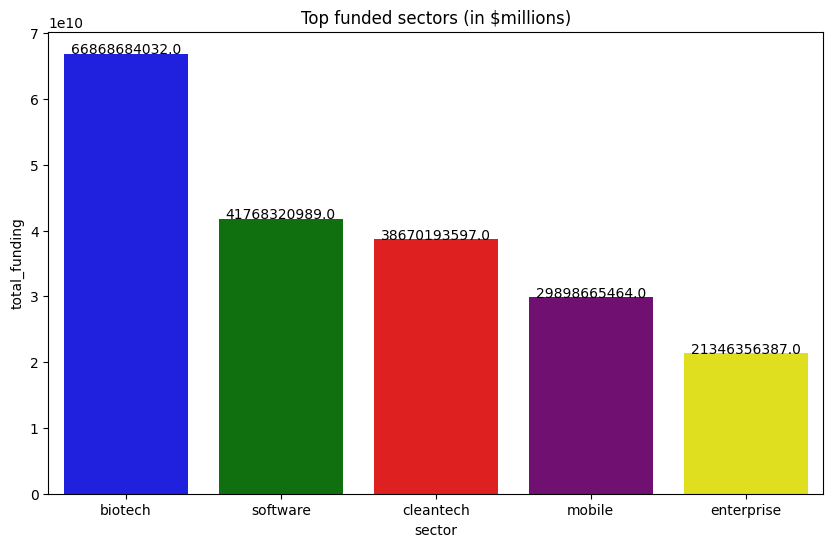

In [75]:
colors = ['blue', 'green', 'red', 'purple','yellow']
plt.figure(figsize=(10, 6))
sns.barplot(x ='sector',y ='total_funding',data = q1,palette=colors)

for i,v in enumerate(z):
    plt.text(i,v,str(v),ha = 'center')
    
#add labels to the x & y axis
plt.xlabel('sector')
plt.ylabel('total_funding')
plt.title('Top funded sectors (in $millions)')


#display the chart
plt.show()

# Q2: Which are the top 3 startups with the highest funding amounts in the top 5 funded sectors?

In [112]:
query2 = '''
with top_funded_sectors as (
select name,sum(funding_total_usd) as total_funding, sector from companies_cleaned_data 
group by name,sector
order by sum(funding_total_usd) desc
limit 5),

ranked_startups AS (
    SELECT name, sector, funding_total_usd,
    rank() OVER (PARTITION BY sector ORDER BY funding_total_usd DESC) as ranks
    FROM companies_cleaned_data
    WHERE sector in (SELECT sector FROM top_funded_sectors)
)

select name,sector,funding_total_usd from ranked_startups
where ranks<=3;
'''

In [113]:
q2 = pd.read_sql(query2,que)
print(q2)

                            name   sector  funding_total_usd
0                     carestream  biotech       2.400000e+09
1         vertex pharmaceuticals  biotech       5.980000e+08
2                        crucell  biotech       4.430000e+08
3                      sigmacare   health       2.600000e+09
4               liberty dialysis   health       3.149600e+08
5                            kaz   health       2.600000e+08
6                      clearwire   mobile       5.700000e+09
7   verizon communications, inc.   mobile       3.985050e+09
8                  united mobile   mobile       5.150000e+08
9                       facebook   social       2.425700e+09
10                       twitter   social       1.160167e+09
11                     pinterest   social       5.625000e+08


## Q3: Which sectors have the highest Average Funding Amounts? (Top 5)

In [122]:
query3 = '''
select sector, count(funding_rounds) as funding_rounds,round(avg(funding_total_usd),2) as avg_funding from companies_cleaned_data
group by sector
order by avg(funding_total_usd) desc
limit 5
'''
q3 = pd.read_sql(query3,que)
print(q3)
z1 = q3['avg_funding']

            sector  funding_rounds  avg_funding
0       automotive              74  48570550.65
1         nanotech              55  39278007.55
2        cleantech             987  39179527.45
3       government               9  27442611.11
4  network_hosting             453  27273072.25


Text(0.5, 1.0, 'Top 5 highest Average Funding Amounts')

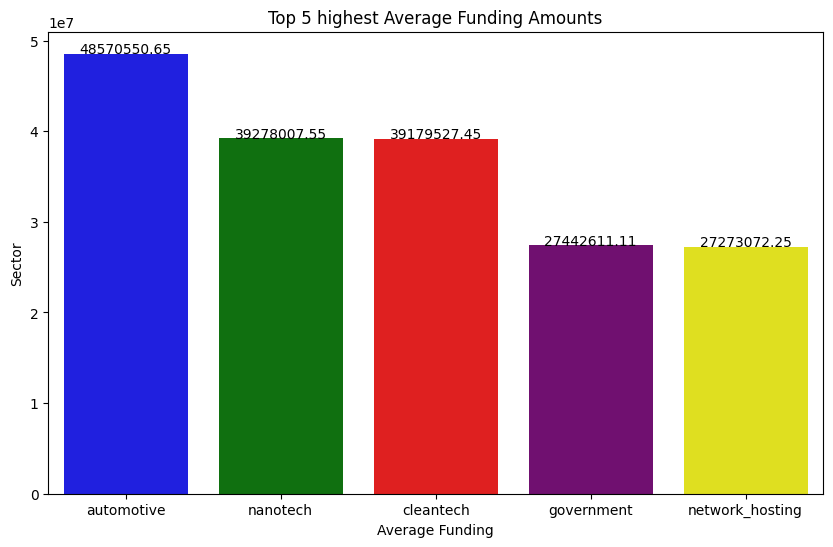

In [123]:
# Visual representation of highest Average Funding Amounts.
colors = ['blue', 'green', 'red', 'purple','yellow']
plt.figure(figsize=(10, 6))
sns.barplot(x='sector',y='avg_funding',data=q3,palette=colors)

for i,v in enumerate(z1):
    plt.text(i,v,str(v),ha='center')

plt.xlabel('Average Funding')
plt.ylabel('Sector')
plt.title('Top 5 highest Average Funding Amounts')

## Q4: Trends of Funding Received by Startups Founded Between 2000 and 2014

Text(0.5, 1.0, ' Funding Received by Startups')

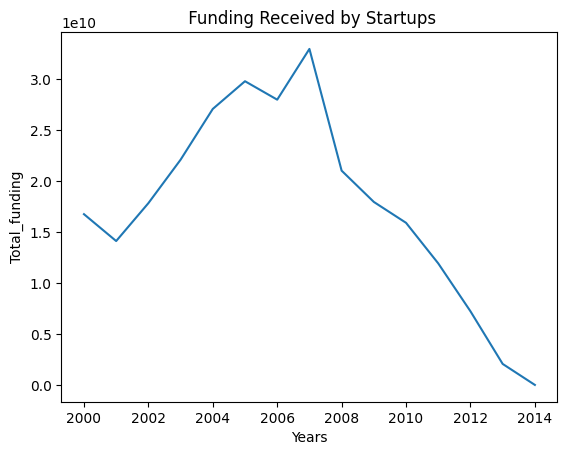

In [144]:
query4 = '''
select round(sum(funding_total_usd),2) as total_funding, YEAR(founded_at) as Years from companies_cleaned_data
where YEAR(founded_at) between 2000 and 2014
group by YEAR(founded_at)
order by YEAR(founded_at)
'''

q4 = pd.read_sql(query4,que)
# print(q4)

sns.lineplot(x='Years',y='total_funding',data=q4)
plt.xlabel('Years')
plt.ylabel('Total_funding')
plt.title(' Funding Received by Startups')

## Q5:The funding size and share of funding of companies per their current status

In [151]:
query5 = '''
select status,count(funding_total_usd) as counts,FORMAT(SUM(funding_total_usd),2) AS overall_funding,
FORMAT(AVG(funding_total_usd),2) AS average_funding from companies_cleaned_data
group by status
'''
q5 = pd.read_sql(query5,que)
print(q5)

      status  counts     overall_funding average_funding
0  operating   23311  299,198,993,434.00   12,835,099.03
1   acquired    2335   51,438,935,514.00   22,029,522.70
2        ipo     480   47,823,105,276.00   99,631,469.32
3     closed    1748   14,534,655,993.00    8,315,020.59


## Q6:Which companies IPOed and how much did they raise?

In [162]:
df_new['status'].unique()

array(['operating', 'acquired', 'ipo', 'closed'], dtype=object)

                           name  total_funding
0  verizon communications, inc.   3.985050e+09
1                      facebook   2.425700e+09
2                       twitter   1.160167e+09
3                       groupon   1.147288e+09
4                         xerox   1.100000e+09


Text(0.5, 1.0, 'Companies IPO most Funded')

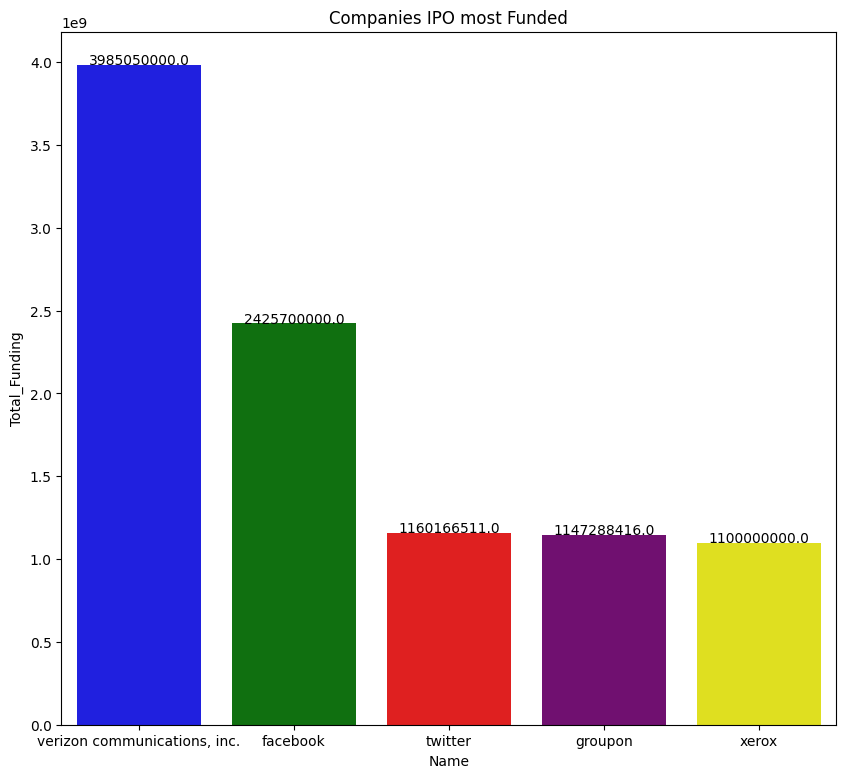

In [174]:
query6 = '''
select name, sum(funding_total_usd) as total_funding from companies_cleaned_data
where status = 'ipo'
group by name
order by sum(funding_total_usd) desc 
limit 5
'''
q6 = pd.read_sql(query6,que)
print(q6)

z2 = q6['total_funding']

colors = ['blue', 'green', 'red', 'purple','yellow']
plt.figure(figsize=(10,9))
sns.barplot(x='name',y='total_funding',data=q6,palette=colors)

for i,v in enumerate(z2):
    plt.text(i,v,str(v),ha='center')

plt.xlabel('Name')
plt.ylabel('Total_Funding')
plt.title('Companies IPO most Funded')

## Q7:Distribution of funding raised by companies across the world

  country_code  total_funding
0          USA   3.105884e+11
1          GBR   1.770562e+10
2                1.085592e+10
3          CHN   1.068974e+10
4          CAN   9.866362e+09


Text(0.5, 1.0, 'Funding raised by companies across the world')

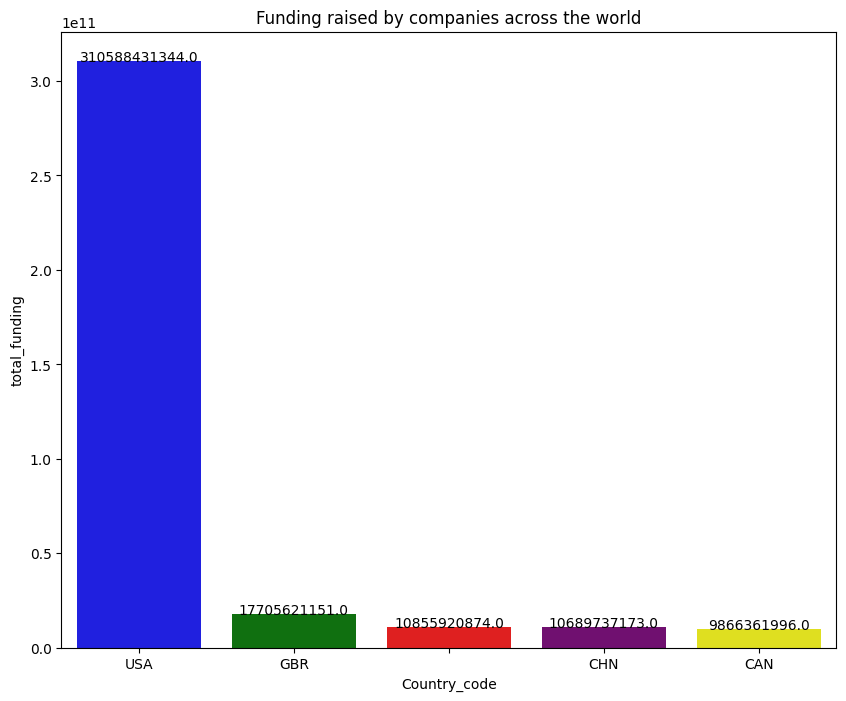

In [182]:
query7 = """
SELECT country_code,
    SUM(funding_total_usd) AS total_funding
    FROM companies_cleaned_data
    GROUP BY country_code
    ORDER BY total_funding DESC
    limit 5;
"""
q7 = pd.read_sql(query7,que)
print(q7)

z3 = q7['total_funding']

plt.figure(figsize=(10,8))
colors = ['blue', 'green', 'red', 'purple','yellow']
sns.barplot(x='country_code',y='total_funding',data=q7,palette=colors)

for i,v in enumerate(z3):
    plt.text(i,v,str(v),ha='center')

plt.xlabel('Country_code')
plt.ylabel('total_funding')
plt.title('Funding raised by companies across the world') 

In [148]:
df_new.head(2)

,id,permalink,name,homepage_url,sector,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at
0,1,/company/wetpaint,wetpaint,http://wetpaint-inc.com,web,39750000.0,operating,USA,WA,seattle,seattle,3.0,2005-10-17
1,2,/company/friendfeed,friendfeed,http://friendfeed.com,web,5000000.0,acquired,USA,CA,sf bay,mountain view,1.0,2007-10-01


## Q8:Which companies raised significant funding but are currently shut down?

            name  total_funding
0  united mobile    515000000.0
1   abound solar    510000000.0
2   amp'd mobile    374000000.0
3  altrabiofuels    228500000.0
4       solfocus    211403000.0


Text(0.5, 1.0, ' companies raised significant funding but are currently shut down')

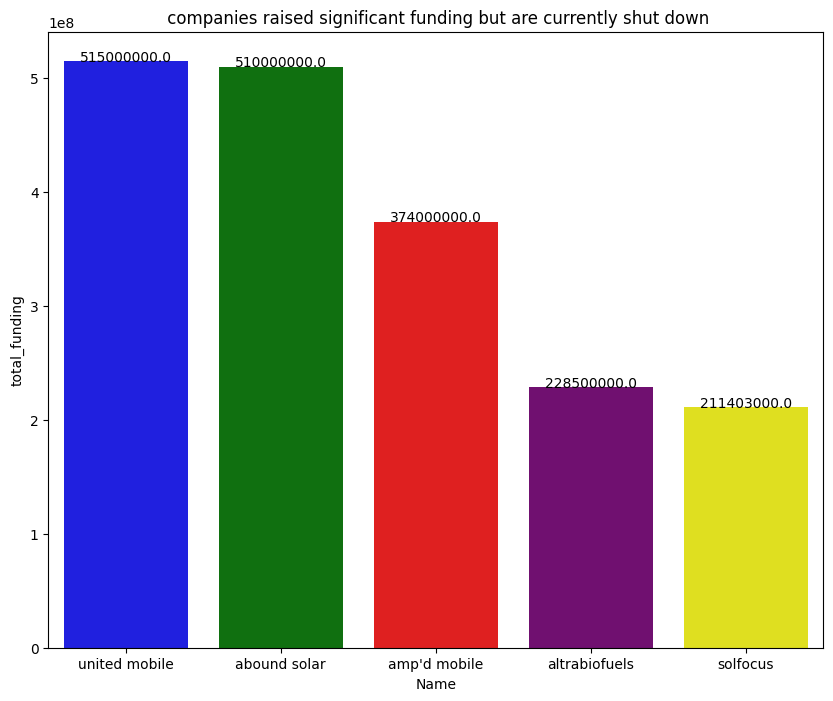

In [185]:
query8 = """
SELECT name,
    SUM(funding_total_usd) AS total_funding
    FROM companies_cleaned_data
    where status = 'closed'
    GROUP BY name
    ORDER BY total_funding DESC
    limit 5;
"""
q8 = pd.read_sql(query8,que)
print(q8)

z4 = q8['total_funding']

plt.figure(figsize=(10,8))
colors = ['blue', 'green', 'red', 'purple','yellow']
sns.barplot(x='name',y='total_funding',data=q8,palette=colors)

for i,v in enumerate(z4):
    plt.text(i,v,str(v),ha='center')

plt.xlabel('Name')
plt.ylabel('total_funding')
plt.title(' companies raised significant funding but are currently shut down') 
